# Курсовая работа по курсу "Математическое моделирование и вычислительный эксперимент"
# Вариант № 2
# Бабичева Анна
# М8О-404Б-17

Импортирую необходимые библиотеки:

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random

import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from matplotlib.animation import FuncAnimation
plt.style.use('seaborn-pastel')

### Задание. Требуется численно решить задачу уравнений газовой динамики и построить соответствующие графики.

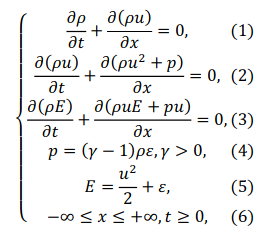

Начальные условия:

$\rho(x,0)=
\begin{cases}
    2, 0 \leq x \leq 0.5
    \\
    1, 0.5 < x < 1
\end{cases}
$

$u(x,0)=
\begin{cases}
    0, 0 \leq x \leq 0.5
    \\
    0, 0.5 < x < 1
\end{cases}
$

$\epsilon(x,0)=
\begin{cases}
    2, 0 \leq x \leq 0.5
    \\
    1, 0.5 < x < 1
\end{cases}
$

In [2]:
# ro в начальный момент
def Pi0(x, i):
    if x[i] <= 0.5:
        return 2.
    return 1.
# u в начальный момент
def ui0(x, i):
    if x[i] <= 0.5:
        return 0.
    return 0.
# epsilon в начальный момент
def ei0(x, i):
    if x[i] <= 0.5:
        return 2.
    return 1.

Условия периодичности при $k \in \mathbb Z$:

$\rho(x+k,t)=\rho(x,t)$

$u(x+k,t)=u(x,t)$

$\epsilon(x+k,t)=\epsilon(x,t)$

Для составления конечно-разностной схемы требуется решить:

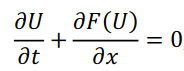

где $F(U)$ - функция от переменной $U$.

Тогда соответствующая аппроксимация конечными разностями:

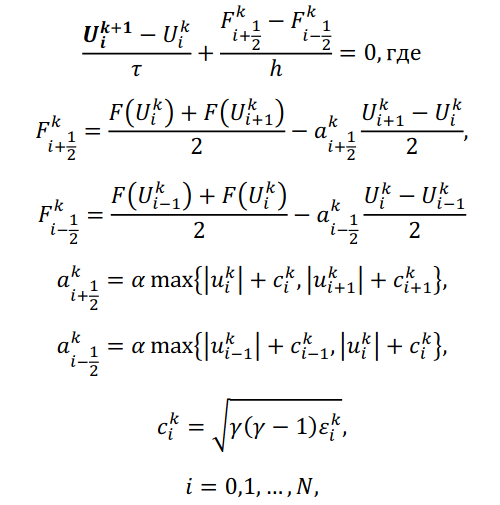

Распишем схему для уравнений (1) - (3).

1. $U=\rho,\quad F(U)=\rho u$

$F^k_{1+\frac{1}{2}}=\frac{\rho^k_iu^k_i+\rho^k_{i+1}u^k_{i+1}}{2}-a^k_{i+\frac{1}{2}}\frac{\rho^k_{i+1}-\rho^k_i}{2}$

$F^k_{1-\frac{1}{2}}=\frac{\rho^k_iu^k_i+\rho^k_{i-1}u^k_{i-1}}{2}-a^k_{i-\frac{1}{2}}\frac{\rho^k_{i}-\rho^k_{i-1}}{2}$

## $$\rho^{k+1}_i=\rho^k_i-\frac{\tau}{h}(F^k_{1+\frac{1}{2}}-F^k_{1+\frac{1}{2}})$$

2. $U=\rho u,\quad F(U)=\rho u^2+p$

$F^k_{1+\frac{1}{2}}=\frac{\rho^k_i(u^k_i)^2+p^k_i+\rho^k_{i+1}(u^k_{i+1})^2+p^k_{i+1}}{2}-a^k_{i+\frac{1}{2}}\frac{\rho^k_{i+1}u^k_{i+1}-\rho^k_iu^k_i}{2}$

$F^k_{1-\frac{1}{2}}=\frac{\rho^k_i(u^k_i)^2+p^k_i+\rho^k_{i-1}(u^k_{i-1})^2+p^k_{i-1}}{2}-a^k_{i-\frac{1}{2}}\frac{\rho^k_iu^k_i-\rho^k_{i-1}u^k_{i-1}}{2}$

## $$u^{k+1}_i=\frac{\rho^k_iu^k_i-\frac{\tau}{h}(F^k_{1+\frac{1}{2}}-F^k_{1+\frac{1}{2}})}{\rho^{k+1}_i}$$

3. $U=\rho E,\quad F(U)=\rho uE+pu$

$F^k_{1+\frac{1}{2}}=\frac{\rho^k_iu^k_iE^k_i+p^k_iu^k_i+\rho^k_{i+1}u^k_{i+1}E^k_{i+1}+p^k_{i+1}u^k_{i+1}}{2}-a^k_{i+\frac{1}{2}}\frac{\rho^k_{i+1}E^k_{i+1}-\rho^k_iE^k_i}{2}$

$F^k_{1-\frac{1}{2}}=\frac{\rho^k_iu^k_iE^k_i+p^k_iu^k_i+\rho^k_{i-1}u^k_{i-1}E^k_{i-1}+p^k_{i-1}u^k_{i-1}}{2}-a^k_{i-\frac{1}{2}}\frac{\rho^k_iE^k_i-\rho^k_{i-1}E^k_{i-1}}{2}$

## $$E^{k+1}_i=\frac{\rho^k_iE^k_i-\frac{\tau}{h}(F^k_{1+\frac{1}{2}}-F^k_{1+\frac{1}{2}})}{\rho^{k+1}_i}$$

## $$\epsilon_i^{k+1}=E_i^{k+1}-\frac{(u_i^{k+1})^2}{2}$$

## $$P_i^{k+1}=(\gamma-1)\rho_i^{k+1}\epsilon_i^{k+1}$$

Где $\alpha$ - параметр, $\gamma=\frac{7}{5}$, $c_i^k=\sqrt{\gamma(\gamma-1)\epsilon_i^k}$, $i=0...N-1$, $k=0...T$.

In [3]:
alpha = 1.
gamma = 7 / 5

## Реализация алгоритма

In [4]:
# функция вычисления c
def c_func(e, k, i):
    return math.sqrt((gamma * (gamma - 1) * e[k][i]))
# функция вычисления epsilon
def e_func(E, u, k, i):
    return E[k][i] - (u[k][i] ** 2) / 2
# функция вычисления p
def p_func(P, e, k, i):
    return (gamma - 1) * P[k][i] * e[k][i]

In [5]:
def solver(T=1., N=100, K=400):
    
    # шаг по времени
    tau = T / K
    # шаг по x
    h = 1. / N

    # значения на оси x
    x = [i * h for i in range(N + 1)]
    # значения на промежутке времени
    t = [k * tau for k in range(K + 1)]
    
    # инициализация функций
    P = np.zeros((K + 1, N + 1))
    u = np.zeros((K + 1, N + 1))
    e = np.zeros((K + 1, N + 1))
    E = np.zeros((K + 1, N + 1))
    p = np.zeros((K + 1, N + 1))
    # инициализация c
    c = np.zeros((K + 1, N + 1))

    # заполнение начальными значениями
    for i in range(N + 1):
        P[0][i] = Pi0(x, i)
        u[0][i] = ui0(x, i)
        e[0][i] = ei0(x, i)
        E[0][i] = e[0][i] + (u[0][i] ** 2) / 2
        p[0][i] = p_func(P, e, 0, i)
        
        c[0][i] = c_func(e, 0, i)

    # идем по слоям
    for k in range(K):
        # идем по x
        for i in range(N + 1):
            # рассчет на левой границе
            if i == 0:
                # параметр a 
                a_p = alpha * max(abs(u[k][i]) + c[k][i], abs(u[k][i + 1]) + c[k][i + 1])
                a_m = alpha * max(abs(u[k][i]) + c[k][i], abs(u[k][N - 1]) + c[k][N - 1])
                
                # значения F(U) для ro
                F_p = (P[k][i] * u[k][i] + P[k][i + 1] * u[k][i + 1]) / 2 - a_p * (P[k][i + 1] - P[k][i]) / 2
                F_m = (P[k][i] * u[k][i] + P[k][N - 1] * u[k][N - 1]) / 2 - a_m * (P[k][i] - P[k][N - 1]) / 2                
                # ro на новом слое
                P[k + 1][i] = P[k][i] - (tau / h) * (F_p - F_m)
                
                # значения F(U) для u
                F_p = (P[k][i] * u[k][i] ** 2 + p[k][i] + P[k][i + 1] * u[k][i + 1] ** 2 + p[k][i + 1]) / 2 - a_p * (P[k][i + 1] * u[k][i + 1] - P[k][i] * u[k][i]) / 2
                F_m = (P[k][i] * u[k][i] ** 2 + p[k][i] + P[k][N - 1] * u[k][N - 1] ** 2 + p[k][N - 1]) / 2 - a_m * (P[k][i] * u[k][i] - P[k][N - 1] * u[k][N - 1]) / 2
                # u на новом слое
                u[k + 1][i] = (P[k][i] * u[k][i] - (tau / h) * (F_p - F_m)) / P[k + 1][i]

                # значения F(U) для E
                F_p = (P[k][i] * u[k][i] * E[k][i] + p[k][i] * u[k][i] + P[k][i + 1] * u[k][i + 1] * E[k][i + 1] + p[k][i + 1] * u[k][i + 1]) / 2 - a_p * (P[k][i + 1] * E[k][i + 1] - P[k][i] * E[k][i]) / 2
                F_m = (P[k][i] * u[k][i] * E[k][i] + p[k][i] * u[k][i] + P[k][N - 1] * u[k][N - 1] * E[k][N - 1] + p[k][N - 1] * u[k][N - 1]) / 2 - a_m * (P[k][i] * E[k][i] - P[k][N - 1] * E[k][N - 1]) / 2
                # E на новом слое
                E[k + 1][i] = (P[k][i] * E[k][i] - (tau / h) * (F_p - F_m)) / P[k + 1][i]                
            # рассчет на правой границе
            elif i == N:
                # параметр a 
                a_p = alpha * max(abs(u[k][i]) + c[k][i], abs(u[k][0]) + c[k][0])
                a_m = alpha * max(abs(u[k][i]) + c[k][i], abs(u[k][i - 1]) + c[k][i - 1])
                
                # значения F(U) для ro
                F_p = (P[k][i] * u[k][i] + P[k][0] * u[k][0]) / 2 - a_p * (P[k][0] - P[k][i]) / 2
                F_m = (P[k][i] * u[k][i] + P[k][i - 1] * u[k][i - 1]) / 2 - a_m * (P[k][i] - P[k][i - 1]) / 2
                # ro на новом слое
                P[k + 1][i] = P[k][i] - (tau / h) * (F_p - F_m)

                # значения F(U) для u
                F_p = (P[k][i] * u[k][i] ** 2 + p[k][i] + P[k][0] * u[k][0] ** 2 + p[k][0]) / 2 - a_p * (P[k][0] * u[k][0] - P[k][i] * u[k][i]) / 2
                F_m = (P[k][i] * u[k][i] ** 2 + p[k][i] + P[k][i - 1] * u[k][i - 1] ** 2 + p[k][i - 1]) / 2 - a_m * (P[k][i] * u[k][i] - P[k][i - 1] * u[k][i - 1]) / 2
                # u на новом слое
                u[k + 1][i] = (P[k][i] * u[k][i] - (tau / h) * (F_p - F_m)) / P[k + 1][i]
                
                # значения F(U) для E
                F_p = (P[k][i] * u[k][i] * E[k][i] + p[k][i] * u[k][i] + P[k][0] * u[k][0] * E[k][0] + p[k][0] * u[k][0]) / 2 - a_p * (P[k][0] * E[k][0] - P[k][i] * E[k][i]) / 2
                F_m = (P[k][i] * u[k][i] * E[k][i] + p[k][i] * u[k][i] + P[k][i - 1] * u[k][i - 1] * E[k][i - 1] + p[k][i - 1] * u[k][i - 1]) / 2 - a_m * (P[k][i] * E[k][i] - P[k][i - 1] * E[k][i - 1]) / 2
                # E на новом слое
                E[k + 1][i] = (P[k][i] * E[k][i] - (tau / h) * (F_p - F_m)) / P[k + 1][i]
            # рассчет внутри отрезка
            else:
                # параметр a 
                a_p = alpha * max(abs(u[k][i]) + c[k][i], abs(u[k][i + 1]) + c[k][i + 1]) #a_plus(u, c, k, i)
                a_m = alpha * max(abs(u[k][i]) + c[k][i], abs(u[k][i - 1]) + c[k][i - 1]) #a_minus(u, c, k, i)

                # значения F(U) для ro
                F_p = (P[k][i] * u[k][i] + P[k][i + 1] * u[k][i + 1]) / 2 - a_p * (P[k][i + 1] - P[k][i]) / 2
                F_m = (P[k][i] * u[k][i] + P[k][i - 1] * u[k][i - 1]) / 2 - a_m * (P[k][i] - P[k][i - 1]) / 2
                # ro на новом слое
                P[k + 1][i] = P[k][i] - (tau / h) * (F_p - F_m)
                
                # значения F(U) для u
                F_p = (P[k][i] * u[k][i] ** 2 + p[k][i] + P[k][i + 1] * u[k][i + 1] ** 2 + p[k][i + 1]) / 2 - a_p * (P[k][i + 1] * u[k][i + 1] - P[k][i] * u[k][i]) / 2
                F_m = (P[k][i] * u[k][i] ** 2 + p[k][i] + P[k][i - 1] * u[k][i - 1] ** 2 + p[k][i - 1]) / 2 - a_m * (P[k][i] * u[k][i] - P[k][i - 1] * u[k][i - 1]) / 2
                # u на новом слое
                u[k + 1][i] = (P[k][i] * u[k][i] - (tau / h) * (F_p - F_m)) / P[k + 1][i]
                
                # значения F(U) для E
                F_p = (P[k][i] * u[k][i] * E[k][i] + p[k][i] * u[k][i] + P[k][i + 1] * u[k][i + 1] * E[k][i + 1] + p[k][i + 1] * u[k][i + 1]) / 2 - a_p * (P[k][i + 1] * E[k][i + 1] - P[k][i] * E[k][i]) / 2
                F_m = (P[k][i] * u[k][i] * E[k][i] + p[k][i] * u[k][i] + P[k][i - 1] * u[k][i - 1] * E[k][i - 1] + p[k][i - 1] * u[k][i - 1]) / 2 - a_m * (P[k][i] * E[k][i] - P[k][i - 1] * E[k][i - 1]) / 2
                # E на новом слое
                E[k + 1][i] = (P[k][i] * E[k][i] - (tau / h) * (F_p - F_m)) / P[k + 1][i]
            
            # epsilon на новом слое
            e[k + 1][i] =  e_func(E, u, k + 1, i)            
            # p на новом слое
            p[k + 1][i] =  p_func(P, e, k + 1, i) 
            # с на новом слое
            c[k + 1][i] =  c_func(e, k + 1, i) 
            
    return np.array(P), np.array(u), np.array(e), np.array(E), np.array(p), np.array(t), np.array(x)

## Рассчеты с различными шагами по времени и пространству

По времени 4000 делений, по x 1000 делений:

In [6]:
P1, u1, e1, E1, p1, t1, x1 = solver(N=1000, K=4000)

По времени 6000 делений, по x 1500 делений:

In [7]:
P2, u2, e2, E2, p2, t2, x2 = solver(N=1500, K=6000)

## Построение графиков

In [16]:
# функция отрисовки двух функций на одном графике
# можно выбрать желаемый момент времени для отрисовки (по умолчанию 0.1 сек)
def draw(x1, x2, u1, u2, t1, t2, t=0.15):
    t1_ = np.where(t1 == t)[0][0]
    t2_ = np.where(t2 == t)[0][0]
    
    fig = plt.figure(figsize=(17, 10))
    plt.grid()
    plt.plot(x1, u1[t1_], color='red')
    plt.plot(x2, u2[t2_], color='black')

### График $\rho(x,t)$

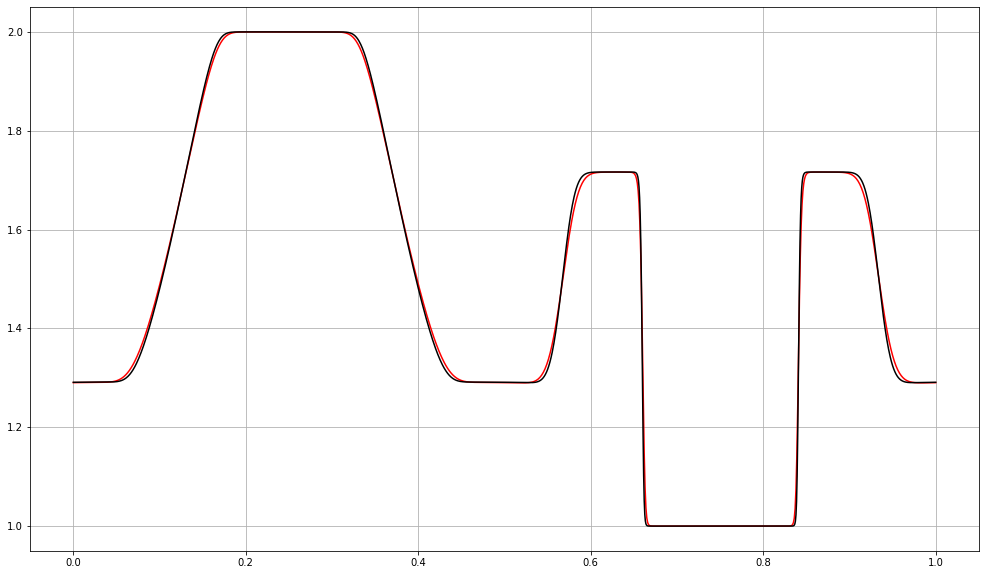

In [17]:
draw(x1, x2, P1, P2, t1, t2)

### График $u(x,t)$

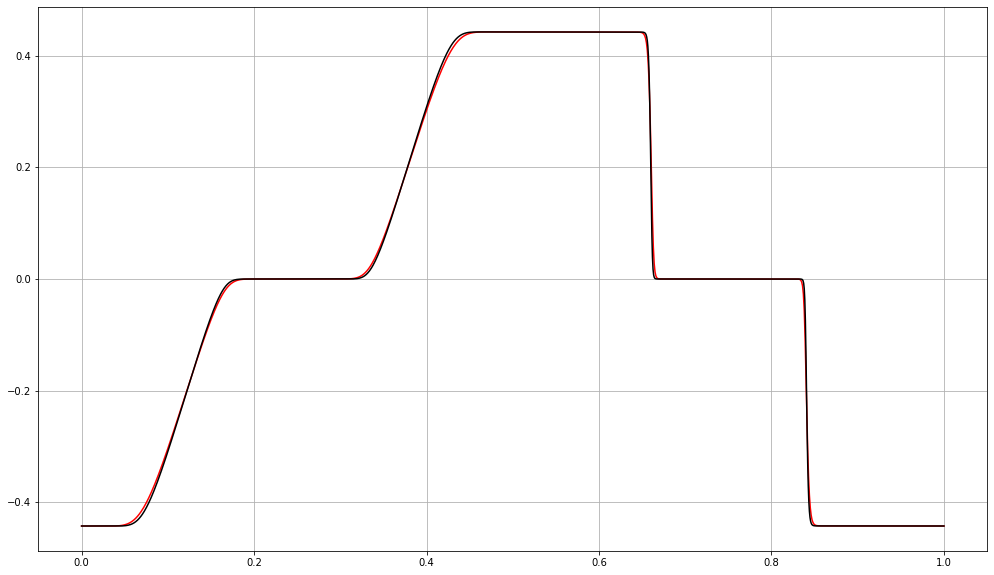

In [18]:
draw(x1, x2, u1, u2, t1, t2)

### График $E(x,t)$

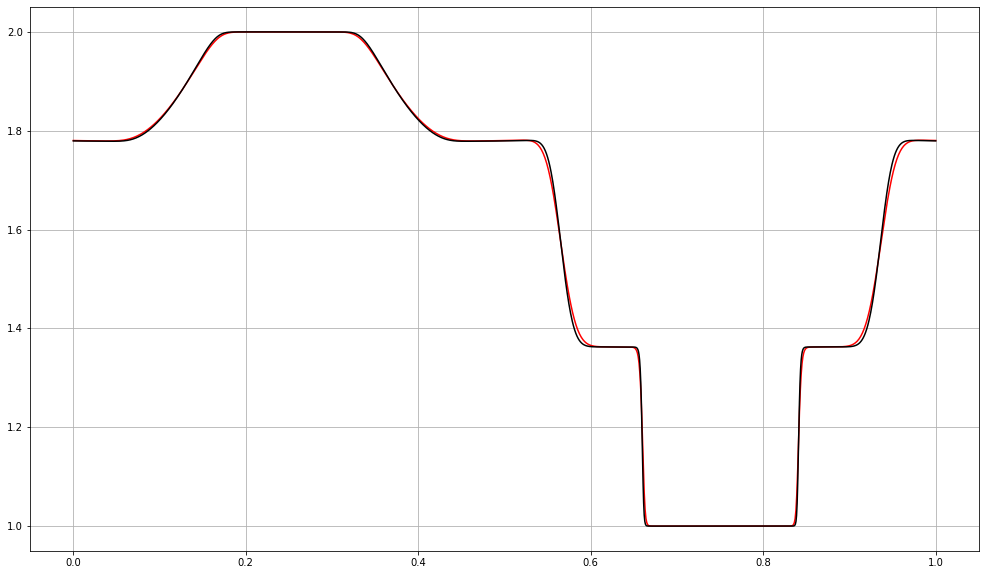

In [19]:
draw(x1, x2, E1, E2, t1, t2)

### График $\epsilon(x,t)$

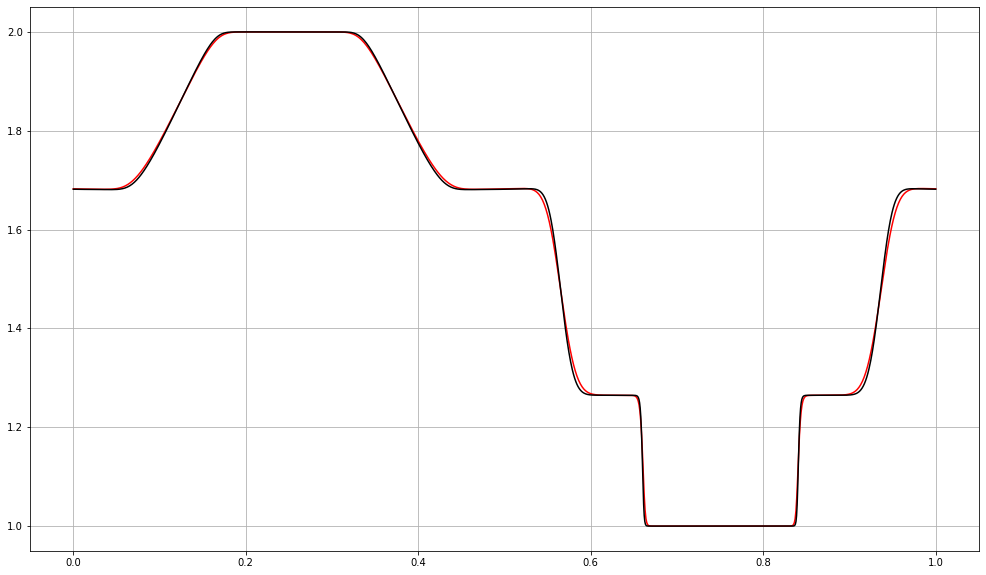

In [20]:
draw(x1, x2, e1, e2, t1, t2)

### График $P(x,t)$

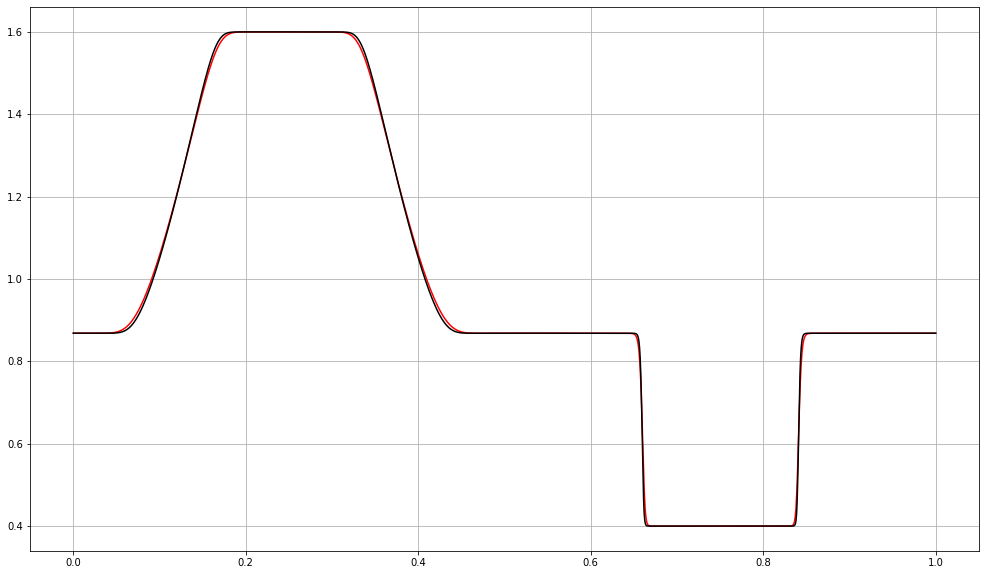

In [21]:
draw(x1, x2, p1, p2, t1, t2)